In [1]:
#import modules
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm

from PIL import Image
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add


In [2]:
#loading the dataset from kaggle
#! pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"svetayelsky","key":"5bb3112126effefcbf271ca7b4eedb6a"}'}

In [3]:
#loading the dataset from kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

#! kaggle datasets list

In [4]:
#Download Data flickr30k
! kaggle datasets download hsankesara/flickr-image-dataset


100% 8.16G/8.16G [06:12<00:00, 24.2MB/s]
100% 8.16G/8.16G [06:12<00:00, 23.5MB/s]


In [128]:
! unzip flickr-image-dataset.zip

In [6]:
# #unzip my smaller training file
# ! unzip flickr30k_images.zip

In [43]:
# # file from google drive
# from google.colab import drive
# drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [127]:
# #unzip from google drive
# !unzip gdrive/My\ Drive/flickr30k_images.zip

In [76]:
Folder = 'flickr30k_images' 
WorkFolder = 'working'

Image features

In [46]:
#building a cnn custom model

cnnmodel = Sequential([
    """
        CNN model built to detect meningful features in images of the dataset
        """
    #convolution
    layers.Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape = (512,512,3)),
    layers.Conv2D(filters=24, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D(pool_size=(4,4)),

    layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    
    layers.Conv2D(filters=24, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    
    layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D(pool_size=(4,4)),
    
    #Flatten and Dense
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(256, activation='relu')
])

In [10]:
cnnmodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 508, 508, 32)      2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 506, 506, 24)      6936      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 126, 126, 24)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 124, 124, 32)      6944      
                                                                 
 conv2d_3 (Conv2D)           (None, 122, 122, 16)      4624      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 61, 61, 16)       0         
 2D)                                                    

In [47]:
# find features in the image
features = {}
directory = Folder + '/flickr30k_images'

for imname in tqdm(os.listdir(directory)): #tqdm for progress bar
    # get image id from folder
    image_id = imname.split('.')[0]
    # load the image from file
    im_path = directory + '/' + imname
    try: #try.. except is added to overcome UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7efff601a770> (.csv file in images folder)
      image = load_img(im_path, target_size=(512, 512)) #target size is an input size for the cnnmodel 1st layer
      # convert image to numpy array and normalizing RGB values between 0 and 1
      image = img_to_array(image)/255
      # reshape data for model adding a dimention to 3 existing RGB dimentions to make it compatable for cnnmodel shape
      image = np.expand_dims(image, axis=0)
      # extract features with CNNmodel
      feature = cnnmodel.predict(image, verbose=0)
      
      # store feature
      features[image_id] = feature
    except Exception as e: #printing the outliyer file name to make sure the actual images wasn't lost
      print(imname)

  0%|          | 0/3746 [00:00<?, ?it/s]

In [12]:
# store features in pickle
pickle.dump(features, open(os.path.join(WorkFolder, 'featurescnn.pkl'), 'wb'))

In [77]:
# load features from pickle (in case it is needed)
with open(os.path.join(WorkFolder, 'featurescnn.pkl'), 'rb') as f:
    features = pickle.load(f)

In [78]:
#plt.imshow(features['1000092795'].reshape(16,16))
features['1000092795'].shape

(1, 256)

Loading captions data from dataset

In [79]:
with open(os.path.join(Folder, 'results.csv'), 'r') as f:
    next(f) #skip first line - because it is the headers of a table
    captions_csv = f.read()

In [80]:
# create mapping of image to captions
mapping = {} #creating an empty dictionary for mapping of captions to corresponding images
# process lines
for line in captions_csv.split('\n'): 
    # split the line by |
    capps = line.split('|')
    if len(line) < 2:
        continue
    image_id, caption = capps[0], capps[2:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list for mapping if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

In [82]:
#Cleaning the captions text
def clean(mapping):
    """Cleans each captions text - converts to lower case, gets read of punctuation, special characters
       and extra spaces. Adding tags to beginning and end of each caption.
        Args:
            dictionary of image's ids coupled with corresponding captions from the dataset
        
        function cleans up the text of each caption in the dictionary. No returned values.
      """
    for imname, captions in mapping.items():
        for i in range(len(captions)):
            ## # take one caption at a time
            ## caption = captions[i]
            # convert text to lowercase
            caption = captions[i].lower()
            # delete special characters and punctuation (everything except of normal letters)
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            #delete camas
            caption = caption.replace(',', '')
            # add start and end tags to the caption
            caption = 'sttag ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endtag'
            captions[i] = caption

In [83]:
# cleaning the text
clean(mapping)

In [8]:
# cleaned caption text
mapping['1000092795'][0]

'sttag two young guys with shaggy hair look at their hands while hanging out in the yard endtag'

In [84]:
#creating captions list and adding all available captions to that list
captions_list = []
for imname in mapping:
    for caption in mapping[imname]:
        captions_list.append(caption)

In [ ]:
#len(captions_list)

In [85]:
#Train Test Validation split 
image_ids = list(mapping.keys())
var = int(len(image_ids) * 0.85)
train = image_ids[:var]
test = image_ids[var:-10]
#saving some images to be unseen by a model for further validation
validation=image_ids[-10:]

In [86]:
len(train)

27015

In [31]:
validation

['9950913',
 '996089206',
 '996712323',
 '99679241',
 '996962407',
 '997338199',
 '997722733',
 '997876722',
 '99804383',
 '998845445']

In [87]:
# tokenize the captions text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions_list)
#calculate vacabulary size
vocab_size = len(tokenizer.word_index) + 1

# get maximum length of the existing captions
max_length = max(len(caption.split()) for caption in captions_list)


In [88]:
vocab_size
#max_length

18319

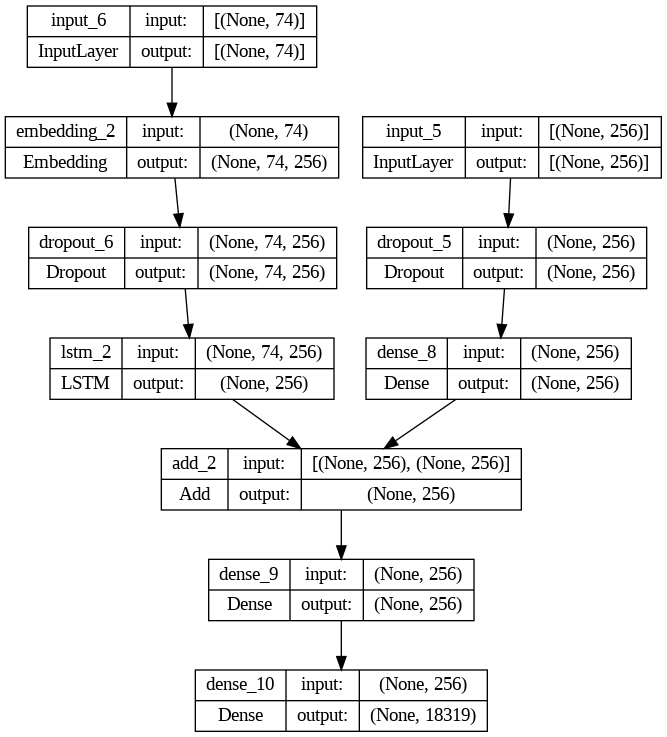

In [89]:
#RNN model creation (with LSTM layer)
#caption prediction from images feature and existing captions model RNN LSTM

# image feature layers 
input_fea = Input(shape=(256,)) #shape based on number of shape of output of the last cnnmodel model layer
drop_fea = Dropout(0.4)(input_fea) #dropout regularisation to reduce overfitting
fea_layer = Dense(256, activation='relu')(drop_fea)

# captions text layers
input_capt = Input(shape=(max_length,)) #shape based on number of characters of longest capture
capt = Embedding(vocab_size, 256, mask_zero=True)(input_capt)
drop_capt = Dropout(0.3)(capt)# additional regularisation to reduce overfitting
capt_layer = LSTM(256)(drop_capt)

 
#combining together image features and captions 
combined = Dense(256, activation='relu')(add([fea_layer, capt_layer]))
outputs = Dense(vocab_size, activation='softmax')(combined) #neurons number = to words in vocabulary from captions

rnnmodel = Model(inputs= [input_fea, input_capt], outputs=outputs)
rnnmodel.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(rnnmodel, show_shapes=True)

In [27]:
rnnmodel.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 74)]         0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 256)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 74, 256)      4689664     ['input_2[0][0]']                
                                                                                                  
 dropout_1 (Dropout)            (None, 256)          0           ['input_1[0][0]']                
                                                                                              

In [126]:
#preparing data for RNN model

#Batches were added to prevent crashing due to insufficient available RAM memory - the bigger the batches more ram needed
batch = 256

X_fea, X_cap, y = list(), list(), list()

b=0
loop = 0
for imn in tqdm(train):
  captions = mapping[imn]
  b=b+1
  
  X_fea_temp, X_cap_temp, y_temp = list(), list(), list()

  # loop through each of the 5 captions per image
  for caption in captions:
    # Transforms each words of caption to a sequence of integers
    words = tokenizer.texts_to_sequences([caption])[0]
    # split the sequence into inputs - output pairs (for future prediction of each next word in the existing caption)
    for i in range(1, len(words)):
      input_words = words[:i]
      targ_word = words[i]
      # pad sequence of inputs to the same length and transforms to np array
      input_words = pad_sequences([input_words], maxlen=max_length)[0]
      # convert targets (output) to binary (to be used in categorical_crosentropy loss function of the model)
      targ_word = to_categorical([targ_word], num_classes=vocab_size)[0]
                  
      try:
        # store the sequences
        X_fea_temp.append(features[imn][0])
        X_cap_temp.append(input_words)
        y_temp.append(targ_word)
      except Exception as e: 
        continue

  if b%batch==0:
    #for i in range(5):
    X_fea.extend(X_fea_temp) 
    X_cap.extend(X_cap_temp)
    y.extend(y_temp)

X_fea.extend(X_fea_temp) #add to list as single items
X_cap.extend(X_cap_temp)
y.extend(y_temp)

#converting lists to arrays
X_fea, X_cap, y = np.array(X_fea), np.array(X_cap), np.array(y)

  0%|          | 0/27015 [00:00<?, ?it/s]

In [91]:
X_fea.shape

(1574, 256)

In [119]:
# train the model in batches (bigger batche model runs slower, and loss is smaller)
epochs = 20
batch_size = 64 #32
steps = len(train) // batch_size

inputs = [X_fea, X_cap]
#train the model
rnnmodel.fit(inputs, y, epochs=epochs, steps_per_epoch=steps, verbose=1)

Epoch 1/20
422/422 [==============================] - 66s 157ms/step - loss: 2.8266
Epoch 2/20
422/422 [==============================] - 66s 155ms/step - loss: 2.6206
Epoch 3/20
422/422 [==============================] - 66s 156ms/step - loss: 2.3543
Epoch 4/20
422/422 [==============================] - 66s 155ms/step - loss: 2.1299
Epoch 5/20
422/422 [==============================] - 66s 156ms/step - loss: 1.8461
Epoch 6/20
422/422 [==============================] - 66s 157ms/step - loss: 1.7009
Epoch 7/20
422/422 [==============================] - 66s 156ms/step - loss: 1.4479
Epoch 8/20
422/422 [==============================] - 65s 155ms/step - loss: 1.3029
Epoch 9/20
422/422 [==============================] - 66s 156ms/step - loss: 1.1024
Epoch 10/20
422/422 [==============================] - 66s 156ms/step - loss: 1.0040
Epoch 11/20
422/422 [==============================] - 66s 157ms/step - loss: 0.8396
Epoch 12/20
422/422 [==============================] - 66s 157ms/step - lo

422/422 [==============================] - 44s 104ms/step - loss: 0.5821


In [122]:
# save the model
rnnmodel.save(WorkFolder+'/rnn_model.h5')

In [129]:
def index_word(index, tokenizer):
    """function loops through vocabulary words and finding the right word based on passed index 
      (argument passed to this function)
        tokenizer.word_index is dictionary of words in vocabulary (all words existing in captions in dataset)
        Args:
            index - index of max probability of a word (at place for word in the caption)
            tokenizer - tokenized (vectorised) captions taxt

        function returns the word corresponding to recived index
      """
    for word, ind in tokenizer.word_index.items():
        if ind == index:
            return word


In [124]:
# generate caption for the image

def generate_caption(image, tokenizer, max_length, model):
    """Cleans each captions text - converts to lower case, gets read of punctuation, special characters
       and extra spaces. Adding tags to beginning and end of each caption.
        Args:
            image  -  specific image to caption
            tokenizer - tokenized (vectorised) captions taxt
            max_length - maximal length of cqptions in the dataset
            model - RNN model for caption prediction
        
        function returns sentence that is a predicted caption for an image 
      """

    # add start tag as a first word of the caption
    in_text = 'sttag'

    for i in range(max_length):
        # Transforms words to a sequence of integers
        seq = tokenizer.texts_to_sequences([in_text])[0]
        # pad sequence of inputs to the same length and converts to np array
        seq = pad_sequences([seq], max_length)
        # predict next word with RNN model
        w_next = model.predict([image, seq], verbose=0)
        # index of maximal value of probability from model prediction
        w_next = np.argmax(w_next)
        # convert index to word (function code in above cell)
        word = index_word(w_next, tokenizer)

        # break the loop if no word is found
        if word is None:
            break
        # adding the word to a sentence
        in_text += " " + word
        # break the loop when code meets an end tag
        if word == 'endtag':
            break
      
    return in_text

In [ ]:
# #load previously saved model
# import tensorflow as tf
# model = tf.keras.models.load_model(WORKING_DIR+'/rnn_model.h5')

In [125]:
from nltk.translate.bleu_score import corpus_bleu
# prediction and evaluation with BLEU scores
captions_real = list()
predicted = list()

for imname in tqdm(test): #tqdm for progress bar
    # get actual existing caption
    captions = mapping[imname]
    try:
      # predict the caption for image
      y_pred = generate_caption(features[imname], tokenizer, max_length, rnnmodel) 
      # split into words
      actual_captions = [caption.split() for caption in captions]
      y_pred = y_pred.split()
      # append to the list
      captions_real.append(actual_captions)
      predicted.append(y_pred)
    except Exception as e:
      print(imname)
    
# calcuate BLEU match scores between input captions and predicted caption ##BLEU score is better when it's higher (between 0 and 1) 1 is perfect match.
print("BLEU 1-gram score: %f" % corpus_bleu(captions_real, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU 2-gram score: %f" % corpus_bleu(captions_real, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/1000 [00:00<?, ?it/s]

BLEU 1-gram score: 0.400654
BLEU 2-gram score: 0.133820


Displaying model outputs next to image and existing captions

In [117]:
def print_caption(imname):
    """function displays predicted captions alongside existed ones and the corresponding image itself
        Args:
            full name of an image in format 'image.jpg'
        
        function prints the existing captions (from dataset) and then caption predicted by the model
      """
    # image and captions
    image = Image.open(Folder + '/flickr30k_images/' + imname)
    captions = mapping[imname.split('.')[0]]

    print('Captions from the dataset:')
    for caption in captions:
        #cleaning out sttag and endtag
        caption = caption.replace('sttag', '')
        caption = caption.replace('endtag', '')
        print(caption)

    # predict the caption
    y_pred = generate_caption(features[image_id], tokenizer, max_length, rnnmodel)
    #cleaning out sttag and endtag
    y_pred = y_pred.replace('sttag', '')
    y_pred = y_pred.replace('endtag', '')
    print('Predicted caption: ', y_pred)

    plt.imshow(image)


Captions from the dataset:
 group of people are wearing signs that say on strike while someone is speaking at booth with the presidential seal 
 strike is currently going on and there are lots of people 
 person speaks at protest on college campus 
 woman is speaking at podium outdoors 
 members of strike at yale university 
Predicted caption:   two women are blue shirt and people and people and toys 


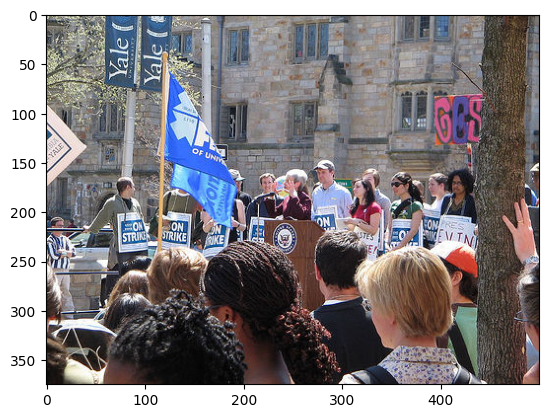

In [118]:
print_caption(validation[0] + ".jpg")